## 8-2. Grover's algorithm

Grover's algorithm is a quantum algorithm for searching for specific data from an unsorted database [1].
Grover's algorithm can find a solution in $O(\sqrt{N})$ queries (calling an oracle) for $N$ unsorted data. Since $O(N)$ queries are required for a classical computer, a quadratic acceleration is achieved by using a quantum algorithm.

Once the oracle is constructed, Grover's algorithm can accelerate the entire search portion of any classical algorithm. For example

- Satisfiability problem (SAT problem)
- The problem of finding the original value from a particular hash value

and the latter has actually been proposed in a paper as a Bitcoin mining acceleration [2].

In this section, we first provide a theoretical explanation of Glover's algorithm and then present an example implementation using Qulacs.

### Algorithm Flow
The flow of Grover's algorithm is simple and is as follows.
As in the previous section, consider the problem of searching for $M$ solutions from a database of $N$ elements, where the element labels are $N$ digit bit sequences $x = x_1 \ldots x_n$.

1. prepare a superposition of all states $|s\rangle = \frac{1}{\sqrt{N}}\sum_x |x\rangle$.
2. apply oracle $U_w$ (reversal operation on the solution)
3. apply the inversion operation $U_s$ with $|s\rangle$ as the axis of symmetry
4. Repeat steps 2 and 3 $k$ times
5. perform the measurement

Let's look at each step in detail.

#### 1. prepare a superposition state of all states $|s\rangle = \frac{1}{\sqrt{N}}\sum_x |x\rangle$.
This is easy. For the initial state $|0\cdots0\rangle$, we can apply Hadamard gate $H$ to all qubits.

$$
 (H\otimes \cdots \otimes H) |0\cdots0\rangle = \frac{1}{(\sqrt{2})^n} (|0\rangle+|1\rangle) \otimes \cdots \otimes (|0\rangle+|1\rangle)
 = |s\rangle
$$


#### 2. Apply the oracle $U_w$ (reversal operation on the solution)
Next, we let the oracle act on the state $|s\rangle$.
Here, as an oracle, we will consider the operation "if $x$ is a solution to the input $|x\rangle$, the phase is inverted by multiplying by (-1), and if it is not a solution, nothing is done" as described at the end of [previous section](8.1_oracle.ipynb), and the auxiliary bits are omitted. In other words, define the oracle $U_w$ as follows.

$$
 U_w = I - 2\sum_{w\in \text{solution}}|w\rangle \langle w|,  
$$

$$
 U_w|x\rangle =  
\begin{cases}
 |x\rangle  \:\: \text{(x is not solution)} \\
 -|x\rangle \:\: \text{(x is solution)}
\end{cases}
$$

The oracle $U_w$ is called an "inversion operation on the solution" because it inverts the phase only when the input is a solution.

#### 3. Applying the inversion operation $U_s$ with $|s\rangle$ as the axis of symmetry
In step 2, we considered the inversion operation on the solution, and in step 3, we will apply the inversion operation $U_s$ with the superposition of all states $|s\rangle$ as the axis of symmetry.

$$
 U_s = 2 |s\rangle \langle s| - I
$$

This operator acts on input state $|\psi\rangle = a|s\rangle + b|s_\perp\rangle$ ($|s_\perp\rangle$ is a vector orthogonal to $|s\rangle$)as follows

$$
 U_s|\psi\rangle = a |s\rangle - b|s_\perp\rangle
$$

and inverts only the phase of the part proportional to $|s_\perp\rangle$.

#### 4. Repeat steps 2 and 3 $k$ times
Repeat the above two inversion operations $U_w$ and $U_s$. As we will see later, approximately $O(\sqrt{N/M})$ iterations are sufficient to obtain a solution with high enough probability for the next step 5 measurement. In other words, the number of times to call the oracle is $O(\sqrt{N})$.

#### 5. Take a measurement
After the steps up to this point, the state is $(U_s U_w)^k | s \rangle$. $k$ is the number of iterations of steps 2 and 3.
As described below, in fact, (absolute value of) the coefficient of the state $|w\rangle$ corresponding to the solution $w$ is very large in this state, so if we perform the measurement in the computational basis, we can obtain the solution $w$ (bit string) with a high probability.


Roughly speaking, this is the only operation to be performed in Grover's algorithm, and it is very simple.

### Geometric Explanation
Next, we provide a geometric explanation of why Grover's algorithm works. (There are other explanations that focus on the average operation of the coefficients, see for example [3].)

#### Definition of a two-dimensional plane
First, consider a two-dimensional plane stretched in the following two states $|\alpha\rangle,|\beta\rangle$.

$$
|\alpha\rangle = \frac{1}{\sqrt{N-M}} \sum_{x \in {not solution}} |x\rangle
$$

$$
|\beta\rangle = \frac{1}{\sqrt{M}}\sum_{x \in solution} |x\rangle
$$  

The superposition state $|s\rangle$ of all states can be expressed as follows, which shows that it is a vector in this 2-dimensional plane.

$$
|s\rangle = \sqrt{\frac{N-M}{N}} |\alpha\rangle + \sqrt{\frac{M}{N}} |\beta\rangle
$$

In particular, using angles which satisfies $\cos{\frac{\theta}{2}} = \sqrt{\frac{N-M}{N}}, \sin{\frac{\theta}{2}} = \sqrt{\frac{M}{N}}$ we can write

$$
|s\rangle = \cos{\frac{\theta}{2}} |\alpha\rangle + \sin{\frac{\theta}{2}} |\beta\rangle
$$

This is illustrated in the following figure.
(Note that since $N \gg{} M$ in general in search problems, $\sqrt{M/N}$ is close to 0 and $\theta$ is often a positive number close to 0.)

![Grovers](figs/8/GroverReflection.png)

#### Two inversion operations $U_s U_w$ = rotation in a two-dimensional plane 
Considering in this plane, the oracle $U_w$ is an inversion operation with respect to the $|\beta\rangle$ axis ($U_w|\alpha\rangle =|\alpha\rangle, U_w|\beta\rangle = -|\beta\rangle$).
Therefore, after applying $U_w$, applying inversion $U_s$ with $|s\rangle$ as the symmetry axis will result in a rotation in the $|\alpha\rangle,|\beta\rangle$ plane by an angle $\theta$. (see the figure).

Since Grover's algorithm repeats $U_s U_w$ $k$ times, the state is rotated $k$ times, and just before the measurement

$$
 (U_s U_w)^k |s\rangle = \cos{\frac{(2k+1)\theta}{2}} |\alpha\rangle + \sin{\frac{(2k+1)\theta}{2}} |\beta\rangle
$$

When $N \gg M$ , $\theta$ was a positive number close to zero, so each time $|s\rangle$ was acted on by $U_s U_w$, the coefficient of $|\alpha\rangle$ would decrease and that of $|\beta\rangle$ would increase.
Since $|\beta\rangle$ was made up of a superposition of all solution states, this means that the probability of obtaining a solution increases when $(U_s U_w)^k |s\rangle$ is measured.

This is  the reasons why Glover's algorithm can successfully search for solutions.

#### Estimating the optimal $k$.
Finally, let's evaluate how much $k$, the number of times to act on $U_s U_w$, i.e., how many times to call the oracle.
This will determine the computational complexity.

The closest $(U_s U_w)^k |s\rangle$ comes to $|\beta\rangle$ is when $\frac{(2k+1)\theta}{2}$ is close to $\frac{\pi}{2}$, that is when $k$ is

$$
 R = \text{ClosestInteger}\left( \frac{\pi}{2\theta} -\frac{1}{2} \right)
$$

ここで $\text{ClosestInteger}(\ldots)$ は $\ldots$ に最も近い整数を表す。
$R$の上限を評価しよう。 $\theta > 0$ について成り立つ式

where $\text{ClosestInteger}(\ldots)$ denotes the integer closest to $\ldots$.
Let us evaluate the upper bound of $R$. 

$$
 \frac{\theta}{2} \geq  \sin \frac{\theta}{2} = \sqrt{\frac{M}{N}}
$$

With the above equation that hold for $\theta > 0$, we get

$$
 R \leq \left( \frac{\pi}{2\theta} -\frac{1}{2} \right) + 1 = \frac{\pi}{2\theta} + \frac{1}{2} \leq \frac{\pi}{4}\sqrt{\frac{N}{M}} + \frac{1}{2}
$$


That is, $R$ is at most $O(\sqrt{N/M})$ and Grover's algorithm works with $O(\sqrt{N})$.

### Example Implementation
Let us try to implement Grover's algorithm using Qulacs. (The implementation code is almost the same as in [4].

In [1]:
## Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #Pauli operator
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #Rotation operations on Pauli operators

## Run only if you are in a Google Colaboratory / (Linux or Mac) jupyter notebook environment.
## Qulacs errors will be output normally.
!pip3 install wurlitzer
%load_ext wurlitzer

In [2]:
## Function to plot the distribution of absolute values of coefficients
def show_distribution(state,nqubits):
    plt.bar([i for i in range(pow(2,nqubits))], abs(state.get_vector()))
    plt.show()

#### Checking the operation
First, let's implement Grover's algorithm with 5 qubits and check its operation.
The superposition state of all states $|s\rangle$ can be created by acting on all bits of the state $|0\cdots0\rangle$ with Hadamard gate.

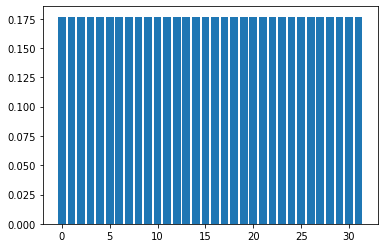

In [3]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state,nqubits)

Next, we create the oracle $U_w$. Here we set $|1\ldots1\rangle$ as the solution, and create an operator that adds a phase (-1) to only $|1\ldots1\rangle$.
Such an operator can be implemented as "an operator that apply the $Z$ gate on the `nqubits`th qubit when all qubits from the `0`th to the `nqubits-1`th are `1`.
The implementation uses Qulacs special gate `to_matrix_gate`. Also, we use `control_index` and `control_with_value`.

In [4]:
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # apply gate only if i-th qubits are all 1's
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

Checking the action of the oracle, we can see that indeed only the last component ($|1\cdots1\rangle$) is inverted in phase.

In [5]:
hoge = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(hoge)
print(hoge.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


Similarly, create an inversion $U_s$ with $|s\rangle$ as the symmetry axis. Use the following equation holds.

$$
U_s = 2 |s\rangle \langle s| - I = H^{\otimes n} (2 |0\cdots0\rangle \langle0\cdots0| - I) H^{\otimes n}  
$$

In [6]:
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I implementation
    ## First, phase (-1) is given to all states. The gate matrix is arrary([[-1,0],[0,-1]])
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) 
    U_s.add_gate( X(nqubits-1) )
    ## apply the Z-gate only if all i-th qubits are 0
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) ) 

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

Now let's apply $U_s U_w$ just once and see how the probability distribution changes. The probability of all 1 states (the rightmost one) gets slightly larger.

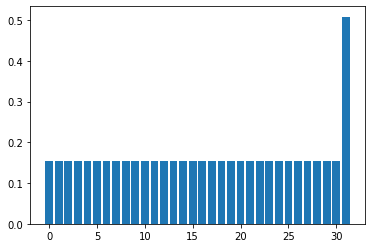

In [7]:
## Prepare initial state
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

## apply U_s U_w 
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state,nqubits)

Repeat this a few times and you'll see.

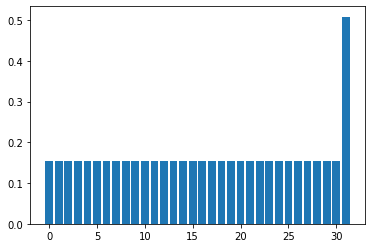

0.5082329989778305


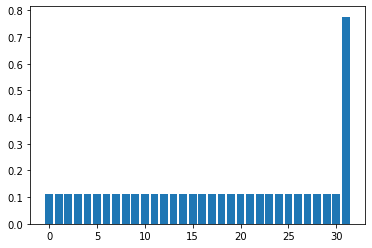

0.7761601777867947


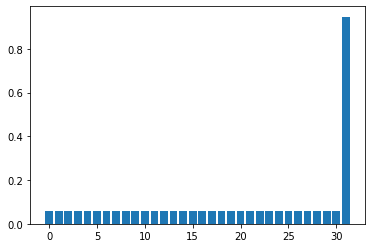

0.9470673343724091


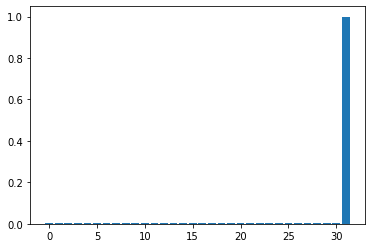

0.9995910741614723


In [8]:
## Create a solution state |1....1> to evaluate the inner product.
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 is a binary number 1.... .1 
    
## Run Grover's algorithm
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state,nqubits)
    print(np.linalg.norm(inner_product(state, target_state)))

After about $k=4$ iterations, we got a solution state with probability almost 1.
Let `nqubits` be a bit larger and check the behavior of the solution output probability for $k$.

maximal probability 9.997306e-01 is obtained at k = 25


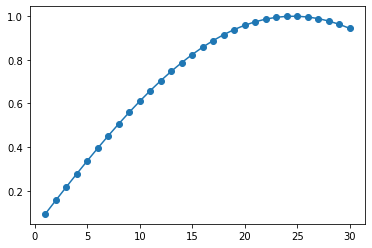

In [9]:
nqubits = 10
state = QuantumState(nqubits)
state.set_zero_state()

## Create a solution state |1....1> to evaluate the inner product.
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 is binary number 1...1 
    
## Run Grover's algorithm
Hadamard = make_Hadamard(nqubits)
U_w= make_U_w(nqubits)
U_s = make_U_s(nqubits)

result = []

state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)
for k in range(30):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    #show_distribution(state,nqubits)
    result.append(np.linalg.norm(inner_product(state, target_state)))

max_k = np.argmax(result)
print( f"maximal probability {result[max_k]:5e} is obtained at k = {max_k+1}")

plt.plot(np.arange(1, 30+1), result, "o-")

The target state is obtained with probability 1 almost $k=25$ times. Also, the $k$ dependence of the probability is a sine function, as we saw in the "Geometric Explanation" section.

Finally, let's see how the $k$ needed to find the solution behaves with respect to the number of qubits.

In [10]:
result = []
min_nqubits = 6
max_nqubits = 16
for nqubits in range(min_nqubits, max_nqubits+1, 2):
    ## Prepare circuit
    Hadamard = make_Hadamard(nqubits)
    U_w= make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    ## Create a solution state |1....1> to evaluate the inner product. 
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 is binary number 1...1 

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)

    ## Multiply U_s U_w until the probability starts to decrease
    tmp = 0
    flag = 0
    num_iter = 0
    while flag == 0 and num_iter <= 1000:
        num_iter += 1
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        suc_prob = np.linalg.norm(inner_product(state, target_state))
        if tmp < suc_prob:
            tmp = suc_prob
        else: 
            flag = 1
    result.append( [nqubits, num_iter, suc_prob] )
    print(f"nqubits={nqubits}, num_iter={num_iter}, suc_prob={suc_prob:5e}")

nqubits=6, num_iter=7, suc_prob=9.526013e-01
nqubits=8, num_iter=13, suc_prob=9.930691e-01
nqubits=10, num_iter=26, suc_prob=9.963280e-01
nqubits=12, num_iter=51, suc_prob=9.992534e-01
nqubits=14, num_iter=101, suc_prob=9.998851e-01
nqubits=16, num_iter=202, suc_prob=9.999368e-01


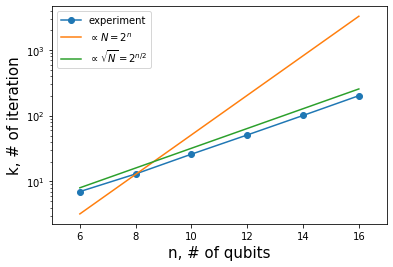

In [11]:
result_array = np.array(result)

plt.xlim(min_nqubits-1, max_nqubits+1)
plt.xlabel("n, # of qubits", fontsize=15)
plt.ylabel("k, # of iteration", fontsize=15)
plt.semilogy(result_array[:,0], result_array[:,1], "o-", label="experiment")
plt.semilogy(result_array[:,0], 0.05*2**result_array[:,0], "-", label=r"$\propto N=2^n$")
plt.semilogy(result_array[:,0], 2**(0.5*result_array[:,0]), "-", label=r"$\propto \sqrt{N}=2^{n/2}$")
plt.legend(fontsize=10)

The number of iterations = the number of oracle calls $k$ is proportional to $O(\sqrt{N})$, not $O(N)$.

### Appendix
Interested readers are encouraged to use Grover's algorithm to solve the convenience store placement problem [IBM Quantum Challenge 2019 contest problem](https://github.com/quantum-challenge/2019/blob/master/problems/final/Final.ipynb). An [example solution](https://github.com/quantum-challenge/2019/blob/master/problems/final/answer_and_comment_by_judges.ipynb) has also been uploaded.

### Reference

[1] M. A. Nielsen and I. L. Chuang, `6.1 The quantum search algorithm` of “Quantum Computation and Quantum Information 10th Anniversary Edition“, University Printing House     
[2] D. Aggarwal, G. Brennen, T. Lee, M. Santha, and M. Tomamichel, “Quantum Attacks on Bitcoin, and How to Protect Against Them“, Ledger, [S.l.], v. 3, oct. 2018, https://ledgerjournal.org/ojs/index.php/ledger/article/view/127   
[3] IBM Quantum Challenge 2019, Week 2 notebook https://github.com/quantum-challenge/2019/blob/master/problems/week2/week2.ipynb   
[4] Keisuke Fujii, “Implement the Grover Search Quantum Algorithm in depth.“, https://github.com/keisukefujii/QulacsExamples/blob/master/GroverSearch.ipynb